In [16]:
import scipy
import numpy as np

import openeo
from openeo.extra.spectral_indices import compute_indices

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import rasterio
from rasterio.plot import show

In [17]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [18]:
extent = {"west": 19.45, "south": 78.798, "east": 20.73, "north": 79.99}

In [19]:
# define a function to identify cloud-free pixels in the available data-cube


def getBAP(scl, data, reducer="first"):
    mask = (scl == 3) | (scl == 8) | (scl == 9) | (scl == 10)

    # mask is a bit noisy, so we apply smoothening
    # 2D gaussian kernel
    g = scipy.signal.windows.gaussian(11, std=1.6)
    kernel = np.outer(g, g)
    kernel = kernel / kernel.sum()

    # Morphological dilation of mask: convolution + threshold
    mask = mask.apply_kernel(kernel)
    mask = mask > 0.1

    data_masked = data.mask(mask)

    # now select Best Available Pixel based on the mask
    return data_masked.reduce_dimension(reducer=reducer, dimension="t")

In [20]:
# load S2 pre-collection
s2pre = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2023-05-03", "2023-08-03"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2pre_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2023-05-03", "2023-08-03"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

# calculate ndvi
ndvi_pre = s2pre.ndvi()

In [21]:
# Create a Pre-event cloud free mosiac
ndvi_pre = getBAP(s2pre_scl, ndvi_pre, reducer="last")

In [22]:
ndvi_pre.download("NDVI.tiff")

OpenEoApiError: [500] Internal: Server error: Exception during Spark execution: org.apache.spark.SparkException: Job aborted due to stage failure: ShuffleMapStage 110510 (load_collection: read by input product) has failed the maximum allowable number of times: 4. Most recent failure reason:
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:437)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1232)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:971)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:86)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:31)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.util.collection.ExternalAppendOnlyMap.insertAll(ExternalAppendOnlyMap.scala:155)
	at org.apache.spark.Aggregator.combineValuesByKey(Aggregator.scala:41)
	at org.apache.spark.shuffle.BlockStoreShuffleReader.read(BlockStoreShuffleReader.scala:124)
	at org.apache.spark.rdd.ShuffledRDD.compute(ShuffledRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.sch... (ref: r-241230fbcafc4b9a8fad827cc51c0bf8)

In [10]:
# load S2 Near-real-time(NRT) collection
s2nrt = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2023-08-03", "2023-08-08"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2nrt_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2023-08-03", "2023-08-08"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

ndvi_nrt = s2nrt.ndvi()
ndvi_nrt = getBAP(s2nrt_scl, ndvi_nrt, reducer="first")

In [11]:
# download NDVI for NRT mode for comparison
ndvi_nrt.download("NRT_NDVI.tiff")

In [12]:
# download signal of fire in near real time
fire_nrt = ndvi_pre - ndvi_nrt
fire_nrt.download("NRT_Fire.tiff")

In [13]:
# load S2 post collection
s2post = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2023-08-03", "2023-11-03"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2post_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2023-08-03", "2023-11-03"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

# calculate post ndvi mosaic
ndvi_post = s2post.ndvi()
ndvi_post = getBAP(s2post_scl, ndvi_post, reducer="first")

In [14]:
# download NDVI for post-event mode for comparison
ndvi_post.download("Post_NDVI.tiff")

OpenEoApiError: [500] Internal: Server error: Exception during Spark execution: org.apache.spark.SparkException: Job aborted due to stage failure: ShuffleMapStage 107638 (load_collection: read by input product) has failed the maximum allowable number of times: 4. Most recent failure reason:
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:437)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1232)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:971)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:86)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:31)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.util.collection.ExternalAppendOnlyMap.insertAll(ExternalAppendOnlyMap.scala:155)
	at org.apache.spark.Aggregator.combineValuesByKey(Aggregator.scala:41)
	at org.apache.spark.shuffle.BlockStoreShuffleReader.read(BlockStoreShuffleReader.scala:124)
	at org.apache.spark.rdd.ShuffledRDD.compute(ShuffledRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.sch... (ref: r-241230c551b64803880333ec8ebe2bb8)

In [ ]:
fire_mosiac = ndvi_pre - ndvi_post
fire_mosiac.download("Mosiac_Fire.tiff")

OpenEoApiError: [500] Internal: Server error: A part of your process graph failed multiple times. Simply try submitting again, or use batch job logs to find more detailed information in case of persistent failures. Increasing executor memory may help if the root cause is not clear from the logs. (ref: r-24123092de9a4d5c9d59cf56765db52f)

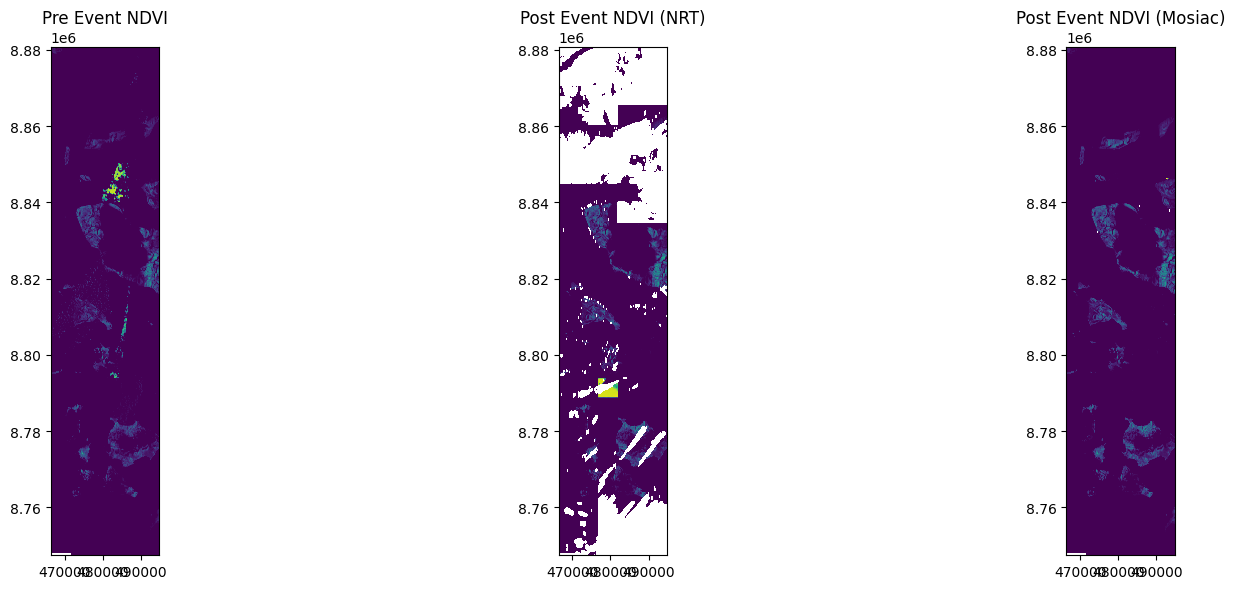

In [14]:
ndvi = rasterio.open("NDVI.tiff")
ndvi_nrt = rasterio.open("NRT_NDVI.tiff")
ndvi_mosiac = rasterio.open("Post_NDVI.tiff")

f, axarr = plt.subplots(1, 3, dpi=100, figsize=(18, 6))
im = show(ndvi.read(1), vmin=0, vmax=1, transform=ndvi.transform, ax=axarr[0])
axarr[0].set_title("Pre Event NDVI")

im = show(ndvi_nrt.read(1), vmin=0, vmax=1, transform=ndvi_nrt.transform, ax=axarr[1])
axarr[1].set_title("Post Event NDVI (NRT)")

im = show(
    ndvi_mosiac.read(1), vmin=0, vmax=1, transform=ndvi_mosiac.transform, ax=axarr[2]
)
axarr[2].set_title("Post Event NDVI (Mosiac)")
plt.tight_layout()

In [15]:
fire_nrt = rasterio.open("NRT_Fire.tiff")
fire_mosiac = rasterio.open("Mosiac_Fire.tiff")

cmap = matplotlib.colors.ListedColormap(["black", "firebrick"])
values = ["Absence", "Presence"]
colors = ["black", "firebrick"]

f, axarr = plt.subplots(1, 2, dpi=100, figsize=(12, 6))

im = show(
    fire_nrt.read(1) > 0.5,
    vmin=0,
    vmax=1,
    transform=fire_nrt.transform,
    ax=axarr[0],
    cmap=cmap,
)
axarr[0].set_title("Forest Fire NRT mode")

im = show(
    fire_mosiac.read(1) > 0.5,
    vmin=0,
    vmax=1,
    transform=fire_mosiac.transform,
    ax=axarr[1],
    cmap=cmap,
)
axarr[1].set_title("Forest Fire Post Mode")
patches = [
    mpatches.Patch(color=colors[i], label="Fire {l}".format(l=values[i]))
    for i in range(len(values))
]
f.legend(handles=patches, bbox_to_anchor=(0.95, 0.2), loc=1)
plt.tight_layout()

RasterioIOError: Mosiac_Fire.tiff: No such file or directory

In [ ]:
#With Normalized Burn Ratio(NBR)

In [16]:
nbr_pre = compute_indices(s2pre, indices=["NBR"])
nbr_pre = getBAP(s2pre_scl, nbr_pre, reducer="last")

In [18]:
nbr_pre.download("NBR.tiff")

In [19]:
nbr_nrt = compute_indices(s2nrt, indices=["NBR"])
nbr_nrt = getBAP(s2nrt_scl, nbr_nrt, reducer="first")

In [20]:
nbr_nrt.download("NRT_NBR.tiff")

In [21]:
# download signal of fire in near real-time
fire_nrt_nbr = nbr_pre - nbr_nrt
fire_nrt_nbr.download("NRT_NBR_Fire.tiff")

In [22]:
nbr_post = compute_indices(s2post, indices=["NBR"])
nbr_post = getBAP(s2post_scl, nbr_post, reducer="first")

In [23]:
nbr_post.download("Post_NBR.tiff")

In [25]:
fire_nrt_mosiac = nbr_pre - nbr_post
fire_nrt_mosiac.download("Mosiac_NBR_Fire.tiff")

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

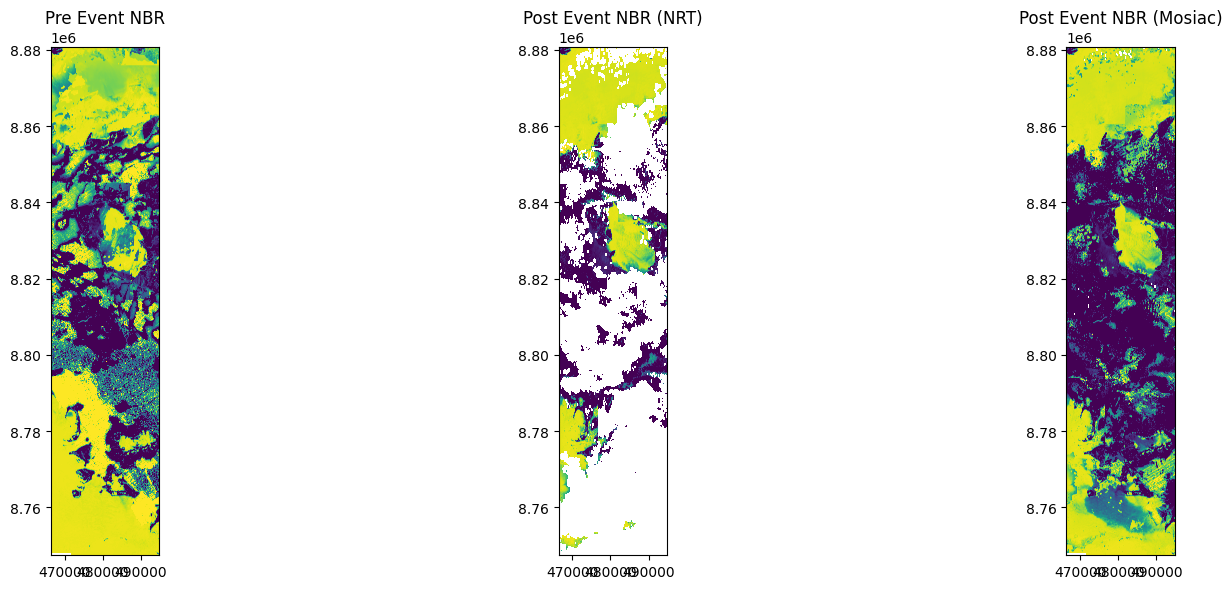

In [ ]:
nbr = rasterio.open("NBR.tiff")
nbr_nrt = rasterio.open("NRT_NBR.tiff")
nbr_mosiac = rasterio.open("Post_NBR.tiff")

f, axarr = plt.subplots(1, 3, dpi=100, figsize=(18, 6))
im = show(nbr.read(1), vmin=0, vmax=1, transform=nbr.transform, ax=axarr[0])
axarr[0].set_title("Pre Event NBR")

im = show(nbr_nrt.read(1), vmin=0, vmax=1, transform=nbr_nrt.transform, ax=axarr[1])
axarr[1].set_title("Post Event NBR (NRT)")

im = show(
    nbr_mosiac.read(1), vmin=0, vmax=1, transform=nbr_mosiac.transform, ax=axarr[2]
)
axarr[2].set_title("Post Event NBR (Mosiac)")
plt.tight_layout()

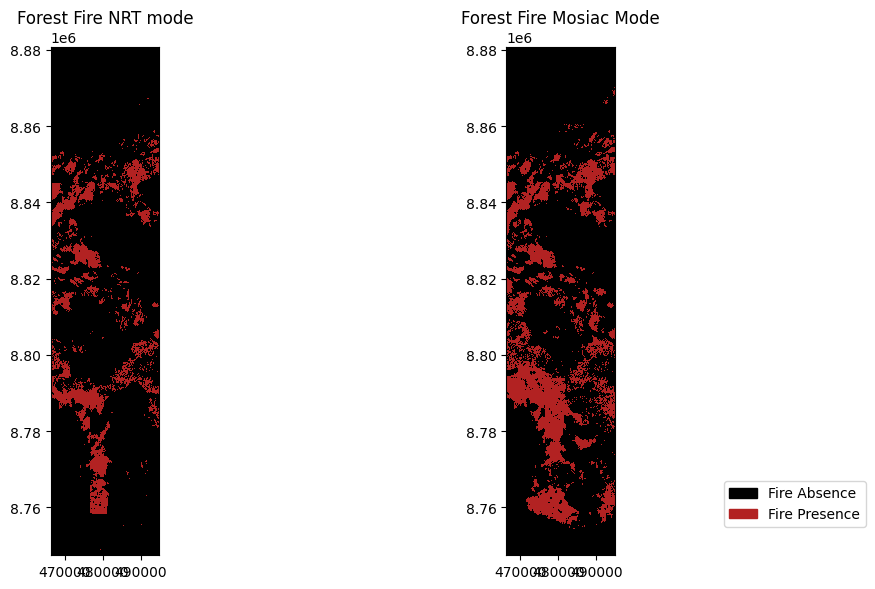

In [ ]:
fire_nbr_nrt = rasterio.open("NRT_NBR_Fire.tiff")
fire_nbr_mosiac = rasterio.open("Mosiac_NBR_Fire.tiff")

cmap = matplotlib.colors.ListedColormap(["black", "firebrick"])
values = ["Absence", "Presence"]
colors = ["black", "firebrick"]

f, axarr = plt.subplots(1, 2, dpi=100, figsize=(12, 6))

im = show(
    fire_nbr_nrt.read(1) > 0.5,
    vmin=0,
    vmax=1,
    transform=fire_nbr_nrt.transform,
    ax=axarr[0],
    cmap=cmap,
)
axarr[0].set_title("Forest Fire NRT mode")

im = show(
    fire_nbr_mosiac.read(1) > 0.5,
    vmin=0,
    vmax=1,
    transform=fire_nbr_mosiac.transform,
    ax=axarr[1],
    cmap=cmap,
)
axarr[1].set_title("Forest Fire Mosiac Mode")
patches = [
    mpatches.Patch(color=colors[i], label="Fire {l}".format(l=values[i]))
    for i in range(len(values))
]
f.legend(handles=patches, bbox_to_anchor=(0.95, 0.2), loc=1)
plt.tight_layout()